In [10]:
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch 
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

In [11]:
%run 00_generate_data.ipynb

ModuleNotFoundError: No module named 'nbformat'

In [3]:
input_data, output_data, qplot = get_data("s")

# TRAINING

In [4]:
X_train = input_data[0:60032]
y_train = output_data[0:60032]

X_val = input_data[61024:81000]
y_val = output_data[61024:81000]

X_test = input_data[81992:100000]
y_test = output_data[81992:100000]

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
input_scaled = scaler.transform(input_data)

In [5]:
def create_sequences(data, labels, time_steps):
    sequences, sequence_labels = [], []
    for i in range(len(data) - time_steps + 1):
        sequences.append(data[i:i + time_steps])
        sequence_labels.append(labels[i + time_steps - 1])  # Label at the end of the sequence
    return np.array(sequences), np.array(sequence_labels)

time_steps = 16
feature_dim = 4

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)
input_seq, output_seq = create_sequences(input_scaled, output_data, time_steps)

In [6]:
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32).unsqueeze(1) 
X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_seq, dtype=torch.float32).unsqueeze(1)
input_tensor = torch.tensor(input_seq, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32)

In [12]:
class TransformerModel(nn.Module):
    def __init__(self, feature_dim=4, embed_dim=16, num_heads=4):
        super().__init__()
        # Project input features to embed_dim for attention
        self.input_proj = nn.Linear(feature_dim, embed_dim)

        self.attention = nn.MultiheadAttention(embed_dim=embed_dim,
                                               num_heads=num_heads,
                                               dropout=0.1,
                                               batch_first=True)

        self.fc1 = nn.Linear(embed_dim, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 4)
        self.fc4 = nn.Linear(4, 2)
        self.out = nn.Linear(2, 1)

    def forward(self, x):
        x = self.input_proj(x)           # project to embed_dim
        attn_output, _ = self.attention(x, x, x)
        pooled = attn_output.mean(dim=1) # GlobalAveragePooling1D
        x = F.relu(self.fc1(pooled))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return torch.sigmoid(self.out(x))

model = TransformerModel()

In [11]:
criterion = nn.BCELoss()  # binary_crossentropy equivalent
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_loader.dataset)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 1/10, Train Loss: 0.3141, Val Loss: 0.2245
Epoch 2/10, Train Loss: 0.1295, Val Loss: 0.1975
Epoch 3/10, Train Loss: 0.0623, Val Loss: 0.3803
Epoch 4/10, Train Loss: 0.0342, Val Loss: 0.0274
Epoch 5/10, Train Loss: 0.0199, Val Loss: 0.0183
Epoch 6/10, Train Loss: 0.0127, Val Loss: 0.0099
Epoch 7/10, Train Loss: 0.0104, Val Loss: 0.0079
Epoch 8/10, Train Loss: 0.0109, Val Loss: 0.0099
Epoch 9/10, Train Loss: 0.0130, Val Loss: 0.0170
Epoch 10/10, Train Loss: 0.0109, Val Loss: 0.0301


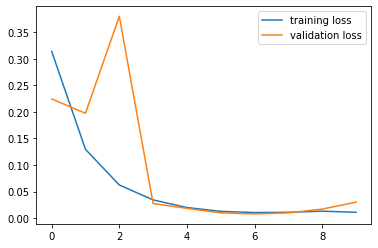

In [12]:
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

In [13]:
model.eval() 

TransformerModel(
  (input_proj): Linear(in_features=4, out_features=16, bias=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
  )
  (fc1): Linear(in_features=16, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=4, bias=True)
  (fc4): Linear(in_features=4, out_features=2, bias=True)
  (out): Linear(in_features=2, out_features=1, bias=True)
)

In [14]:
with torch.no_grad():
    probs = model(input_tensor)        

In [15]:
predictions = probs.numpy() 

In [19]:
predicted_labels = (predictions.squeeze() > 0.5).astype(int)
false_indices = np.where(predicted_labels != output_data[:99985])

In [20]:
accuracy = (1 - len(np.where(false_indices[0] >= 81992)[0])/len(y_test))*100
print(accuracy)

99.75566414926699


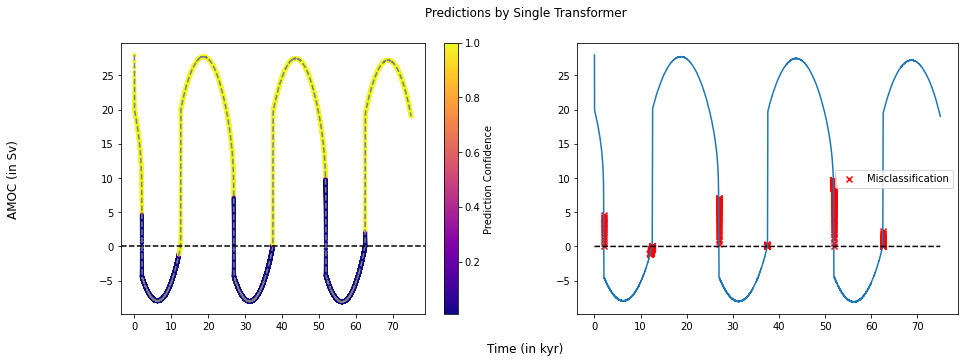

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5));
sc = ax[0].scatter(input_data[:99985, 0], qplot[:99985]/Sv, c=predictions, cmap='plasma', s=10);
ax[0].plot(input_data[:, 0], qplot / Sv, color="grey", linestyle="--");
ax[0].axhline(y=0, color='black', linestyle='dashed');
fig.colorbar(sc, ax=ax[0], label="Prediction Confidence");
ax[1].plot(input_data[:, 0], qplot/Sv);
ax[1].plot(input_data[:, 0], np.zeros_like(input_data[:, 0]), 'k--');
ax[1].scatter(input_data[false_indices, 0], qplot[false_indices]/Sv, marker='x', c='red', label='Misclassification');
fig.suptitle('Predictions by Single Transformer');
fig.supxlabel('Time (in kyr)');
fig.supylabel('AMOC (in Sv)');
plt.legend();

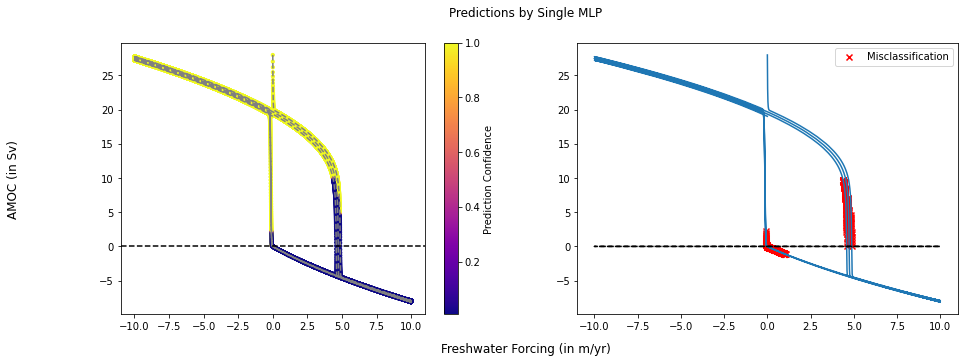

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5));
sc = ax[0].scatter(input_data[:99985, 3]/Fs_to_m_per_year, qplot[:99985]/Sv, c=predictions, cmap='plasma', s=10);
ax[0].plot(input_data[:, 3]/Fs_to_m_per_year, qplot / Sv, color="grey", linestyle="--");
ax[0].axhline(y=0, color='black', linestyle='dashed');
fig.colorbar(sc, ax=ax[0], label="Prediction Confidence");
ax[1].plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv);
ax[1].plot(input_data[:, 3]/Fs_to_m_per_year, np.zeros_like(input_data[:, 3]), 'k--');
ax[1].scatter(input_data[false_indices, 3]/Fs_to_m_per_year, qplot[false_indices]/Sv, marker='x', c='red', label='Misclassification');
fig.suptitle('Predictions by Single MLP');
fig.supxlabel('Freshwater Forcing (in m/yr)');
fig.supylabel('AMOC (in Sv)');
plt.legend();

In [25]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [29]:
!pip3 install transformers

In [4]:
import lxt
import transformers
from transformers import AutoTokenizer
from transformers.models.llama import modeling_llama
from lxt.efficient import monkey_patch
from lxt.utils import pdf_heatmap, clean_tokens

/Applications/anaconda3/envs/hf_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Modify the LLaMA module to compute LRP in the backward pass
monkey_patch(modeling_llama, verbose=True)

Patched LlamaMLP
Patched LlamaRMSNorm
Patched Dropout
Patched transformers.models.llama.modeling_llama


In [7]:
import torch

In [13]:
monkey_patch(model, verbose=True)

AttributeError: 'TransformerModel' object has no attribute '__name__'

# SHAP

In [46]:
import shap

In [52]:
def model_pred(x):
    model.eval() 
    with torch.no_grad():
        probs = model(x)
    return probs

In [78]:
# More samples where AMOC changes rapidly (derivatives)
qplot_smooth = qplot/Sv
q_gradient = np.abs(np.gradient(qplot_smooth))

# Higher sampling probability where gradient is high

gradient_probs = q_gradient / q_gradient.sum()
np.random.seed(42)
sample_indices = np.random.choice(len(qplot), size=200, replace=False, p=gradient_probs)

In [79]:
raw_input_sample = input_data[sample_indices]
qsample = qplot[sample_indices]

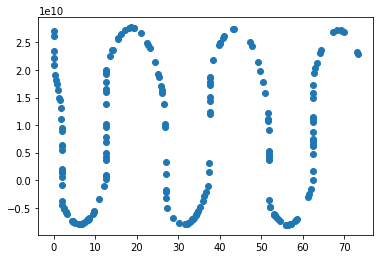

In [80]:
plt.scatter(raw_input_sample[:, 0], qsample)

In [81]:
np.random.seed(123)  # fix the seed for reproducibility

num_background = 100
background_data = shap.sample(X_train_tensor, nsamples=num_background)

In [82]:
feature_names = ['Time', 'Salinity Difference', 'Temperature Difference', 'Freshwater Forcing']
input_sample = input_tensor[sample_indices]

In [83]:
explainer = shap.GradientExplainer(model, background_data)
shap_values = explainer.shap_values(input_sample)

In [84]:
shap_values.shape

(200, 4)

In [85]:
shap_sal = shap_values[:, 1]
shap_temp = shap_values[:, 2]

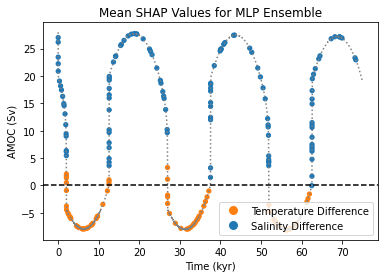

In [86]:
fig, ax = plt.subplots()

# Create color array
colors = np.where(shap_temp > shap_sal, '#ff7f0e', '#1f77b4')

# Single scatter call
scatter = ax.scatter(raw_input_sample[:, 0], qsample/Sv, 
                    c=colors, marker='o', s=18)

ax.set_xlabel('Time (kyr)')
ax.set_ylabel('AMOC (Sv)')
ax.set_title('Mean SHAP Values for MLP Ensemble')
ax.plot(input_data[:, 0], qplot/Sv, linestyle=':', color='grey')
ax.axhline(0, color='black', linestyle='--')

# Manual legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='#ff7f0e', markersize=10),
                 plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='#1f77b4', markersize=10)]
ax.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
          loc='lower right')

# LRP

In [112]:
from captum.attr import LRP, LayerLRP

In [124]:
import torch
import torch.nn as nn
from captum.attr import LRP

# Your working model structure (separate ReLU instances)
class MLPForLRP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 4)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(4, 2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(2, 1)
    
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

# Create the LRP-compatible model
lrp_model = MLPForLRP()

# Copy weights from your trained PyTorch model
lrp_model.fc1.weight.data = model.fc1.weight.data.clone()
lrp_model.fc1.bias.data = model.fc1.bias.data.clone()
lrp_model.fc2.weight.data = model.fc2.weight.data.clone()
lrp_model.fc2.bias.data = model.fc2.bias.data.clone()
lrp_model.fc3.weight.data = model.fc3.weight.data.clone()
lrp_model.fc3.bias.data = model.fc3.bias.data.clone()

lrp_model.eval()

# Run LRP
x = torch.tensor(input_scaled, dtype=torch.float32)
lrp = LRP(lrp_model)
attributions = lrp.attribute(x)
attributions_np = attributions.detach().numpy()

print("LRP shape:", attributions_np.shape)

Input Tensor 0 did not already require gradients, required_grads has been set automatically.


LRP shape: (100000, 4)


In [125]:
lrp = attributions_np

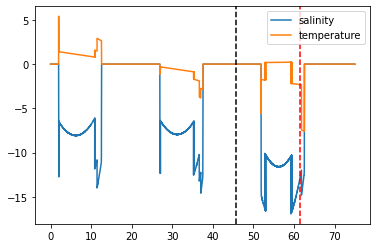

In [128]:
plt.plot(input_data[:, 0], lrp[:, 1], label='salinity')
plt.plot(input_data[:, 0], lrp[:, 2], label='temperature')
plt.axvline(x=input_data[81992, 0], color='red', linestyle='dashed')
plt.axvline(x=input_data[61024, 0], color='black', linestyle='dashed')
plt.legend()